Data downloaded from https://github.com/MahmudulAlam/Complete-Blood-Cell-Count-Dataset

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from datetime import datetime

In [4]:
from datetime import timedelta

In [5]:
import os
import xml.etree.ElementTree as ET

def load_xml_files_to_dict(directory_path):
    xml_files_dict = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.xml'):  # Filter for XML files
            file_path = os.path.join(directory_path, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()
            # If you prefer the entire ElementTree, use `tree` instead of `root` in the dictionary
            xml_files_dict[filename] = root  # Use filename as key and XML root as value
    return xml_files_dict

In [6]:
load_xml_files_to_dict('/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/Training/Annotations/')['BloodImage_00001.xml']

<Element 'annotation' at 0x7fb7477e9360>

In [7]:
import os
import xml.etree.ElementTree as ET

def load_xml_files_and_count_objects(directory_path, tag_name='object'):
    xml_files_dict = {}
    for filename in os.listdir(directory_path):
        if filename.endswith('.xml'):  # Filter for XML files
            file_path = os.path.join(directory_path, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()
            # Count the number of specified elements
            count = len(root.findall('.//' + tag_name))  # Use './/' to search for the tag globally within the tree
            xml_files_dict[filename] = count  # Use filename as key and count as value
    return xml_files_dict

In [8]:
# Replace 'your_folder_path' and 'your_tag_name' with the path to your folder and the tag you're interested in
directory_path = '/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/Training/Annotations/'
tag_name = 'object'  # Replace 'your_tag_name' with the tag you want to count, e.g., 'object'
xml_files_dict = load_xml_files_and_count_objects(directory_path, tag_name)

# Now `xml_files_dict` contains your files' names as keys and counts of the specified tag as values

train_df = pd.DataFrame(data={'path':xml_files_dict.keys(), 'total-count':xml_files_dict.values()})

train_df['path'] = 'Training/Images/'+train_df['path'].str.replace(".xml", ".jpg", regex=False)

In [9]:
# Replace 'your_folder_path' and 'your_tag_name' with the path to your folder and the tag you're interested in
directory_path = '/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/Testing/Annotations/'
tag_name = 'object'  # Replace 'your_tag_name' with the tag you want to count, e.g., 'object'
xml_files_dict = load_xml_files_and_count_objects(directory_path, tag_name)

# Now `xml_files_dict` contains your files' names as keys and counts of the specified tag as values

test_df = pd.DataFrame(data={'path':xml_files_dict.keys(), 'total-count':xml_files_dict.values()})
test_df['path'] = 'Testing/Images/'+test_df['path'].str.replace(".xml", ".jpg", regex=False)

In [10]:
df = pd.concat([train_df, test_df])

In [11]:
df

,path,total-count
0,Training/Images/BloodImage_00001.jpg,19
1,Training/Images/BloodImage_00159.jpg,9
2,Training/Images/BloodImage_00232.jpg,10
3,Training/Images/BloodImage_00125.jpg,15
4,Training/Images/BloodImage_00235.jpg,4
...,...,...
55,Testing/Images/BloodImage_00378.jpg,16
56,Testing/Images/BloodImage_00344.jpg,14
57,Testing/Images/BloodImage_00395.jpg,17
58,Testing/Images/BloodImage_00343.jpg,12


<Axes: ylabel='Frequency'>

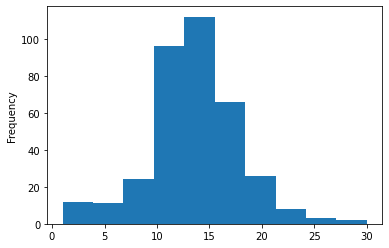

In [12]:
df["total-count"].plot.hist(density=False)

In [13]:
base_path = '/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/'

In [14]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

# Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, base_path = '/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/'):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(base_path+img_path)
        response = torch.tensor(self.dataframe.iloc[idx]['total-count'], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, response
# Custom transform function
def convert_grayscale_to_rgb(image):
    if image.mode != 'RGB':
        return image.convert('RGB')
    return image

# Transforms
transform = transforms.Compose([
    transforms.Lambda(convert_grayscale_to_rgb),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and DataLoader
dataset = CustomImageDataset(df, transform=transform, base_path=base_path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

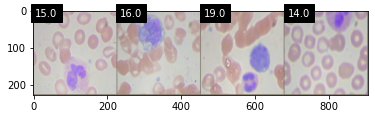

In [15]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Modified imshow function with label positions
def imshow(img, labels, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], num_images_per_row=4):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

    # Get the height and width of the image grid
    grid_height, grid_width, _ = img.shape

    # Height of each image
    img_height = grid_height // (len(labels) // num_images_per_row)

    # Display labels
    for idx, label in enumerate(labels):
        x = (idx % num_images_per_row) * img_height
        y = (idx // num_images_per_row) * img_height
        plt.text(x + 5, y + 15, label, color='white', backgroundcolor='black')

    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Make a grid from batch
out = torchvision.utils.make_grid(images)

# Convert labels to a list of strings if necessary
labels = [str(label.item()) for label in labels]

imshow(out, labels, num_images_per_row=4)


In [16]:
# Dataset and DataLoader
dataset = CustomImageDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [17]:
%%time
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18
model = models.resnet18(pretrained=True)

model_features = torch.nn.Sequential(*(list(model.children())[:-1]))

for param in model_features.parameters():
    param.requires_grad = False

model_features.to('cuda')

CPU times: user 3.15 s, sys: 2.78 s, total: 5.93 s
Wall time: 7.67 s


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [18]:
model.fc.in_features

512

In [19]:
%%time
model_features(images.to('cuda')).squeeze().cpu().numpy().shape

CPU times: user 805 ms, sys: 587 ms, total: 1.39 s
Wall time: 1.83 s


(4, 512)

In [20]:
X = np.zeros((df.shape[0], model.fc.in_features))
y = np.zeros((df.shape[0]))

In [21]:
X.shape

(360, 512)

In [22]:
y.shape

(360,)

In [23]:
from tqdm import tqdm

In [24]:
i = 0
for images, labels in tqdm(dataloader):
    num_entries = images.shape[0]

    X[i:(i+num_entries)] = model_features(images.to('cuda')).squeeze().cpu().numpy()

    y[i:(i+num_entries)] = labels.numpy()

    i = i + num_entries

100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


In [25]:
y

array([19.,  9., 10., 15.,  4., 18., 10.,  3., 10., 15., 20., 14.,  2.,
       16., 12., 10.,  4., 10., 14., 13., 16., 17., 24., 12., 15., 20.,
       11., 14., 13., 11., 12., 19.,  6., 19., 18., 17., 13., 13., 10.,
       16., 16., 13., 13., 13., 17., 16., 12., 16., 11., 17., 15., 15.,
       15., 11., 11., 15.,  9., 14., 13., 13.,  8., 10., 16.,  6., 14.,
       17., 10.,  2., 11.,  3., 14., 18.,  6., 12., 14., 18.,  3., 15.,
        4., 23., 15., 19., 17., 17., 12., 15., 25., 10., 18., 12., 15.,
        8.,  8., 21., 15., 13.,  7.,  8., 16., 12.,  4., 11., 18., 14.,
       11., 12., 11., 10., 18., 15., 12.,  9., 20., 18., 14.,  7.,  9.,
       12., 10., 16., 19., 14., 14.,  9., 14., 19., 12., 15., 13., 11.,
        9.,  8., 15., 22.,  2., 11.,  1., 11., 12., 10., 11., 15.,  9.,
       12.,  8., 12., 10., 10., 13., 14., 18., 11., 16., 17., 13., 17.,
       10., 12., 17., 15., 13., 16., 15., 19., 12., 12., 15., 10., 13.,
       10., 11., 12., 13.,  7., 13., 12., 18., 17., 10., 14., 14

In [26]:
np.save('/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/y.npy', y)

In [27]:
np.save('/share/data/willett-group/climate/data/Complete-Blood-Cell-Count-Dataset-master/X.npy', X)